# Event Sequences

In this routine evaluate the data record to find which dates are marked as heat waves by which of the different definitions. The analysis is done largely through calling the external program [CDO](https://code.zmaw.de/projects/cdo). There is a lot that is not ideal about this approach, and it is quite [duck tape style](http://www.joelonsoftware.com/items/2009/09/23.html). The pros of this approach are that it's very piece-wise, and so makes development and error checking easier. Hopefully the sequential logic of using these piece-wise operators create readable code. Also, since all the libraries, even those that call external programs, used in this example are available through [Anaconda](https://www.continuum.io/) it's possible to reproduce these examples without having to overly fine tune an individual computer. If you do attempt to run this code, ** please check the script for errors.** There inevitably are some. There is no attempt here to create a prescriptive and/or definitive routine. Just some people sitting up nights, trying to create simple sketches to illustrate some ideas. You are very welcome to be one of them.

## Set up

### import routines and define variables

In [1]:
#--- Libraries
import matplotlib.pyplot as plt                      # plotting routines
import seaborn as sns                                # more plotting routines
import pandas as pd                                  # statistics packages
import numpy  as np                                  # linear algebra packages
import subprocess                                    # routines for calling external OS commands
import datetime                                      # work with date objects
import os.path                                       # more routines for working with external commands
import time                                          # additional routines for working with dates/times

from pandas.tseries.offsets import *                 # routines to modify time series labels
from netCDF4 import Dataset                          # access NetCDF files
from cdo import *                                    # routines for interacting with NetCDF files
cdo = Cdo()                                          #                    via an external program

In [2]:
# place graphics in the notebook document
%matplotlib inline

# use 'casual' graphic style
_ = plt.xkcd()

In [3]:
#--- Identify regions of interest 
# choose country
country = 'India'
# read file of reported heatwaves
heatwave_data = pd.read_csv('../data/Heatwaves_database.csv')
heatwave_data.loc[heatwave_data.Region==' Tamil Nadu','Region'] = 'Tamil Nadu'
#heatwave_data.Region[heatwave_data.Region==' Tamil Nadu'] = 'Tamil Nadu'
# make list of unique region names for country
regions = list( set(heatwave_data.Region.where(heatwave_data.Country==country)) )
# remove nans (from regions that aren't in the selected country) 
regions = [x.title() for x in regions if str(x) != 'nan']

### Data

To simplfy implementation the definitions are applied to NetCDF files where all data that is not in the selected region has been masked out. 

In [ ]:
#--- Apply mask
# list data variabiles
variables = ["max.daily","min.daily","daily"]
# loop over regions
for i in range(len(regions)) :
    # create region name with no spaces
    reg = "_".join(regions[i].split())
    # loop over number of variables
    for j in range(len(variables)) :
        # choose variable
        var = variables[j]
        # identify regional mask
        maskfile = "../data/"+reg+".mask.nc"
        # identify file with data for given country
        datafile = "../data/"+"".join(country.split(" "))+".t2m."+var+".subset.nc"
        # report files
        print maskfile+" "+datafile,
        print "../data/"+reg+"."+var+".nc"
        # create mask file
        _ = cdo.ifthen(input=maskfile+" "+datafile,
                       output="../data/"+reg+"."+var+".nc")

# also mask the base period file
# loop over regions
for i in range(len(regions)) :
    # create region name with no spaces
    reg = "_".join(regions[i].split())
    # loop over number of variables
    for j in range(len(variables)) :
        # choose variable
        var = variables[j]
        # identify regional mask
        maskfile = "../data/"+reg+".mask.nc"
        # identify file with data for given country
        datafile = "../data/"+country+".basefile.nc"
        # report files
        print maskfile+" "+datafile,
        print "../data/"+reg+"."+var+".nc"
        # create mask file
        _ = cdo.ifthen(input=maskfile+" "+datafile,
                       output="../data/"+reg+".basefile.nc")


## Heat wave definitions

Here we define functions that check the reanalysis data against each of the heat wave definitions. The goal is to create a sequence of 'event/not-event' (in a meteorological context) for the full time series that is considered. In the script the functions are labeled by the reference they are taken from, rather than the more descriptive labels used in the texts (so to have variable names that don't include speical characters). 

In [ ]:
# ============================================================
# Definition: AveRel4 [Fontaine et al 2013]:
# Mean daily temperature > 90th percentile for 4 or more days
# ============================================================
def Fontaine (region) :
    #--- Variables
    thresh_temppctl = 90
    seq_length  = 4
    deflab = 'Fontaine'
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        # calculate 90th percentiles for daily max temp
        cdo.timmin(input = "../data/"+region+".daily.nc", output = "../data/mindaily.nc")
        cdo.timmax(input = "../data/"+region+".daily.nc", output = "../data/maxdaily.nc")
        cdo.timpctl(str(thresh_temppctl),
                    input = "../data/"+region+".daily.nc ../data/mindaily.nc ../data/maxdaily.nc ", 
                    output = "../data/daily90.nc")
        # check each cell for > 90th percentile max temperature
        cdo.gt(str(thresh_temppctl),
               input = "../data/"+region+".daily.nc ../data/daily90.nc", 
               output = "../data/gt90.nc")
        # do windowed sum, so that grid cell has value of 4 if that date, 2 days 
        #  before and day after are all 'true'
        cdo.runsum(str(seq_length),
                   input = "../data/gt90.nc", 
                   output = "../data/eventsinwindow.nc")
        # check for events
        cdo.gec(str(seq_length),
                input = "../data/eventsinwindow.nc", 
                output = "../data/prolongedevents.nc")
        # check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the 2 days before and day after are also events
        cdo.fldmax(input = "../data/prolongedevents.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        # sweep up
        subprocess.call(["rm","../data/mindaily.nc","../data/maxdaily.nc","../data/daily90.nc",
                         "../data/gt90.nc","../data/eventsinwindow.nc","../data/prolongedevents.nc"])
  
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    for i in range(2) :
        metrec.insert(0,int(0))
    for i in range(1) :
        metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(2,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1 ; tmp[i-2] = 1
        elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
            tmp[i+1] = 1 
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add 2 days to start of list (removed by windowed sum)
    for i in range(2) :
        day_alpha = dates[0] - Day()
        dates = dates.insert(0,day_alpha)
    # add 1 days to end of list (removed by windowed sum)
    for i in range(1) :
        day_omega = dates[len(dates)-1] + Day()
        dates = dates.insert(len(dates),day_omega)
    # returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts


In [ ]:
# ============================================================
# Definition: AveRel2(mid) [Anderson and Bell, 2011; CAWCR, 2013]:
# Mean daily temperature > 95th percentile for 2 or more days
# ============================================================

def Anderson (region) :
    #--- Variables
    thresh_temppctl = 95
    seq_length  = 2
    deflab = 'Anderson'
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        ## calculate 90th percentiles for daily max temp
        cdo.timmin(input = "../data/"+region+".daily.nc", output = "../data/mindaily.nc")
        cdo.timmax(input = "../data/"+region+".daily.nc", output = "../data/maxdaily.nc")
        cdo.timpctl(str(thresh_temppctl),
                    input = "../data/"+region+".daily.nc ../data/mindaily.nc ../data/maxdaily.nc ", 
                    output = "../data/daily95.nc")
        ## check each cell for > 90th percentile max temperature
        cdo.gt(str(thresh_temppctl),
               input = "../data/"+region+".daily.nc ../data/daily95.nc", 
               output = "../data/gt95.nc")
        ## Do windowed sum, so that grid cell has value of 2 if that date, and 1 day
        #  before are all 'true'
        cdo.runsum(str(seq_length),
                   input = "../data/gt95.nc", 
                   output = "../data/eventsinwindow.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/eventsinwindow.nc", 
                output = "../data/prolongedevents.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the day before is also an event
        cdo.fldmax(input = "../data/prolongedevents.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/mindaily.nc","../data/maxdaily.nc","../data/daily95.nc",
                         "../data/gt95.nc","../data/eventsinwindow.nc","../data/prolongedevents.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    for i in range(1) :
        metrec.insert(0,int(0))
    # for i in range(1) :
    #     metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(1,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1 
        # elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
        #     tmp[i+1] = 1 
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add 1 day to start of list (removed by windowed sum)
    for i in range(1) :
        day_alpha = dates[0] - Day()
        dates = dates.insert(0,day_alpha)
    #--- Returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts


In [ ]:
# ================================================================
# Definition AveRel3+ [Peng et al., 2001]
# Every portion of sequences of days with daily mean over the 81st
# percentile where at least 3 of those days is above the 97.5th
# percentile, and the average of that portion is above the 97.5th
# percentile.
# ================================================================
def Peng (region) :
    #--- Variables
    deflab = 'Peng'
    #--- Read data
    ## Load temperature variable directly into python
    # open data file
    fh = Dataset("../data/"+region+".daily.nc")
    # pull in temperature variable
    v = fh.variables['air'][:]
    # close data file
    fh.close()
    # take dates from data file
    dates = cdo.showdate(input = "../data/"+region+".daily.nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    #--- List flagged time-indexes (for all grid cells)
    # save results
    matches = []
    # predeclare some variables that get overwritten in the loop 
    qualified_sequences = []
    potential_seq = []
    # loop through grid cells
    for i in range(v.shape[1]) :
        for j in range(v.shape[2]) :
            if not v[0,i,j] is np.ma.masked :
                # example sequance of value 
                x = pd.Series(v[:,i,j])
                # estimate threshold values 
                T1,T2 = x.quantile(0.81),x.quantile(0.975)
                # create list of all indexes that meet all the criteria
                qualified_sequences = []
                # print i,j 
                for m in range(len(x)) :
                    # print m
                    # create list of indexes that meet first criteria
                    potential_seq = []
                    n = m
                    # check that value meets first criteria
                    while ( (x[n] > T1) & ( n < (len(x)-1)) ) :
                        potential_seq.append(n)
                        # if meets remaining criteria
                        if ( (sum(x[potential_seq] > T2) >=3) & (x[potential_seq].mean() > T2) ) :
                            # then note this sequence
                            qualified_sequences.extend(potential_seq)
                        # extend sequence
                        n += 1
            # keep record of indexes in the qualified sequences
            matches.extend(sorted(set(qualified_sequences)))
    ts = pd.Series(0,index=dates)
    ts[dates[sorted(list(set(matches)))]] = 1
    return ts


In [ ]:
# =======================================================================
# Definition: MaxAbs3 [Hansen et al. 2008]:
# Max temperature greater than 35degC for 3 or more days
# =======================================================================
def Hansen(region) :
    #--- Variables 
    deflab = 'Hansen'
    thresh_temp = 35+273
    seq_length  = 3
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        ## check each cell for >= 25degC
        cdo.gtc(str(thresh_temp),
                input = "../data/"+region+".max.daily.nc", 
                output = "../data/tmp00.nc")
        ## Do windowed sum, so that grid cell has value of 3 if that date, day
        #  before and day after are all 'true'
        cdo.runsum(str(seq_length),
                   input = "../data/tmp00.nc", 
                   output = "../data/tmp01.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/tmp01.nc", 
                output = "../data/tmp02.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the day before and day after are also events
        cdo.fldmax(input = "../data/tmp02.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/tmp00.nc","../data/tmp01.nc","../data/tmp02.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates ommited by windowed sum
    metrec.insert(0,int(0))
    metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(1,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1
        elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
            tmp[i+1] = 1
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add one day to start of list (removed by windowed sum)
    day_alpha = dates[0] - Day()
    dates = dates.insert(0,day_alpha)
    # add one day to end of list (removed by windowed sum)
    day_omega = dates[len(dates)-1] + Day()
    dates = dates.insert(len(dates),day_omega)
    #--- returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts


In [ ]:
# =============================================================================
# Definition: AveRel2(high) [Kent et al. 2014]:
# Mean daily temperature > 98th percentile for 2 or more days
# =============================================================================
def Kent_high(region) :
    #--- variables
    deflab = 'Kent_high'
    thresh_temppctl = 98
    seq_length  = 2
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        ## calculate 90th percentiles for daily max temp
        cdo.timmin(input = "../data/"+region+".daily.nc", 
                   output = "../data/mindaily.nc")
        cdo.timmax(input = "../data/"+region+".daily.nc", 
                   output = "../data/maxdaily.nc")
        cdo.timpctl(str(thresh_temppctl),
                    input = "../data/"+region+".daily.nc ../data/mindaily.nc ../data/maxdaily.nc ", 
                    output = "../data/daily95.nc")
        ## check each cell for > 90th percentile max temperature
        cdo.gt(str(thresh_temppctl),
               input = "../data/"+region+".daily.nc ../data/daily95.nc", 
               output = "../data/gt95.nc")
        ## Do windowed sum, so that grid cell has value of 2 if that date, and 1 day
        #  before are all 'true'
        cdo.runsum(str(seq_length),
                   input = "../data/gt95.nc", 
                   output = "../data/eventsinwindow.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/eventsinwindow.nc", 
                output = "../data/prolongedevents.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the day before is also an event
        cdo.fldmax(input = "../data/prolongedevents.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/mindaily.nc","../data/maxdaily.nc","../data/daily95.nc",
                         "../data/gt95.nc","../data/eventsinwindow.nc",
                         "../data/prolongedevents.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    for i in range(1) :
        metrec.insert(0,int(0))
    # for i in range(1) :
    #     metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(1,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1 
        # elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
        #     tmp[i+1] = 1 
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add 1 day to start of list (removed by windowed sum)
    for i in range(1) :
        day_alpha = dates[0] - Day()
        dates = dates.insert(0,day_alpha)
    # # add 1 days to end of list (removed by windowed sum)
    # for i in range(1) :
    #     day_omega = dates[len(dates)-1] + Day()
    #     dates = dates.insert(len(dates),day_omega)
    #--- returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts



In [ ]:
# ========================================================================
# Definition: AvgRel2(low)  [Kent et al. 2014]:
# Mean daily temperature > 90th percentile for 2 or more days
# ========================================================================
def Kent_low (region) :
    #--- Variables
    deflab = 'Kent_low'
    thresh_temppctl = 90
    seq_length  = 2
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        ## calculate 90th percentiles for daily max temp
        cdo.timmin(input = "../data/"+region+".daily.nc", 
                   output = "../data/mindaily.nc")
        cdo.timmax(input = "../data/"+region+".daily.nc", 
                   output = "../data/maxdaily.nc")
        cdo.timpctl(str(thresh_temppctl),
                    input = "../data/"+region+".daily.nc ../data/mindaily.nc ../data/maxdaily.nc ", 
                    output = "../data/daily95.nc")
        ## check each cell for > 90th percentile max temperature
        cdo.gt(str(thresh_temppctl),
               input = "../data/"+region+".daily.nc ../data/daily95.nc", 
               output = "../data/gt95.nc")
        ## Do windowed sum, so that grid cell has value of 2 if that date, and 1 day
        #  before are all 'true'
        cdo.runsum(str(seq_length),input = "../data/gt95.nc", 
                   output = "../data/eventsinwindow.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/eventsinwindow.nc", 
                output = "../data/prolongedevents.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the day before is also an event
        cdo.fldmax(input = "../data/prolongedevents.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/mindaily.nc","../data/maxdaily.nc","../data/daily95.nc",
                         "../data/gt95.nc","../data/eventsinwindow.nc","../data/prolongedevents.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    for i in range(1) :
        metrec.insert(0,int(0))
    # for i in range(1) :
    #     metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(1,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1 
        # elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
        #     tmp[i+1] = 1 
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add 1 day to start of list (removed by windowed sum)
    for i in range(1) :
        day_alpha = dates[0] - Day()
        dates = dates.insert(0,day_alpha)
    # # add 1 days to end of list (removed by windowed sum)
    # for i in range(1) :
    #     day_omega = dates[len(dates)-1] + Day()
    #     dates = dates.insert(len(dates),day_omega)
    #--- returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts


In [ ]:
# =======================================================================
# Definition: MaxAbs2 [Tan et al. 2003]:
# Max temperature greater than 35degC for 2 or more days
# =======================================================================
def Tan(region) :
    #--- Variables
    deflab = 'Tan'
    thresh_temp = 35+273
    seq_length  = 2
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( os.path.exists("../data/eventrec."+deflab+"."+region+".nc") ) :
        print("creating netcdf file")
        ## check each cell for >= 35degC
        cdo.gtc(str(thresh_temp),
                input = "../data/"+region+".max.daily.nc", 
                output = "../data/tmp00.nc")
        ## Do windowed sum, so that grid cell has value of 2 if that date, 
        #  and day after are all 'true'
        cdo.runsum(str(seq_length),
                   input = "../data/tmp00.nc", 
                   output = "../data/tmp01.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/tmp01.nc", 
                output = "../data/tmp02.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the day after is also an event
        cdo.fldmax(input = "../data/tmp02.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/tmp00.nc","../data/tmp01.nc","../data/tmp02.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    # for i in range(1) :
    #     metrec.insert(0,int(0))
    for i in range(1) :
        metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(1,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
            tmp[i+1] = 1 
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # # add one day to start of list (removed by windowed sum)
    # day_alpha = dates[0] - Day()
    # dates = dates.insert(0,day_alpha)
    # add one day to end of list (removed by windowed sum)
    day_omega = dates[len(dates)-1] + Day()
    dates = dates.insert(len(dates),day_omega)
    #--- set data as time series 
    x = pd.Series(metrec, index=dates)
    #--- only consider values between June 15th and September 15th
    x.ix[ (x.index.month < 6) | (x.index.month > 9) ] = 0
    x.ix[ (x.index.month == 6) & (x.index.day < 15) ] = 0
    x.ix[ (x.index.month == 9) & (x.index.day > 15) ] = 0
    ts = x
    #--- returen time series data
    return ts


In [ ]:
# =============================================================
# Definition: MaxRel1(low) [Indian Meteorological Department]:
# Any day that is > 5degC above daily climatology when the
# climatological value is 40degC or below, or any day that is >
# 4degC above daily climatology when climatological value is above
# 40degC, or any day that is above 45degC. 
# =============================================================
def IMD(region) :
    #--- Variables 
    deflab = 'IMD'
    thresh_annom_leq40 = 5
    thresh_annom_gt40  = 4
    thresh_tmp         = 45+273
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) & (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) & (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) ) :
        print("creating netcdf file")
        ## calculate daily climatology of max temperatures
        cdo.ydaymean(input="../data/"+region+".max.daily.nc",
                     output="../data/clim.nc")
        ## calculate anomaly from daily climatology
        cdo.sub(input="../data/"+region+".max.daily.nc ../data/clim.nc", 
                output="../data/annom.nc")
        ## see when/where annom is greater than 5
        cdo.gtc(str(thresh_annom_leq40),
                input = "../data/annom.nc", 
                output = "../data/a_gt5.nc")
        ## see when/where annom is greater than 4
        cdo.gtc(str(thresh_annom_gt40),
                input = "../data/annom.nc", 
                output = "../data/a_gt4.nc")
        # create long term climatology file
        cdo.setrtoc("-100,100,0",
                    input="../data/annom.nc",
                    output="../data/fullnull.nc")
        cdo.add(input="../data/fullnull.nc ../data/clim.nc",
                output="../data/clim.extnd.nc")
        ## see when/where max temp is <= 40
        cdo.lec(str(273+40),
                input="../data/clim.extnd.nc", 
                output="../data/c_le40.nc")
        ## see when/where max temp is > 40
        cdo.gtc(str(273+40),
                input="../data/clim.extnd.nc", 
                output="../data/c_gt40.nc")
        ## only consider annom > 5 when clim <= 40
        cdo.ifthen(input="../data/c_le40.nc ../data/a_gt5.nc",
                   output="../data/conditionA.nc")
        cdo.fldmax(input = "../data/conditionA.nc", 
                   output = "../data/eventrecA."+deflab+"."+region+".nc")
        ## only consider annom > 4 when clim > 40 
        cdo.ifthen(input="../data/c_gt40.nc ../data/a_gt4.nc",
                   output="../data/conditionB.nc")
        cdo.fldmax(input = "../data/conditionB.nc", 
                   output = "../data/eventrecB."+deflab+"."+region+".nc")
        ## see when/where max temp is > 45
        cdo.gtc(str(273+45),
                input="../data/"+region+".max.daily.nc",
                output="../data/conditionC.nc")
        cdo.fldmax(input = "../data/conditionC.nc", 
                   output = "../data/eventrecC."+deflab+"."+region+".nc")
        subprocess.call(["rm","../data/clim.nc","../data/annom.nc","../data/a_gt5.nc","../data/a_gt4.nc",
                         "../data/fullnull.nc","../data/clim.extnd.nc",
                         "../data/c_le40.nc","../data/c_gt40.nc",
                         "../data/conditionA.nc","../data/conditionB.nc","../data/conditionC.nc"])
    #--- Generate time series data
    ## create variable from netcdf data
    # read netcdf file
    metrec_a = cdo.output(input = "../data/eventrecA."+deflab+"."+region+".nc")
    # convert elements to integers 
    metrec_a = [int(x) for x in metrec_a]
    # read netcdf file
    metrec_b = cdo.output(input = "../data/eventrecB."+deflab+"."+region+".nc")
    # convert to floats
    metrec_b = [float(x) for x in metrec_b]
    # set as array
    metrec_b = np.array(metrec_b)
    # find indexes of missing values
    ind_nan = (np.where(metrec_b < 0 )[0])
    # set missing values as null
    metrec_b[ind_nan] = 0
    # set as integers
    metrec_b = [int(x) for x in metrec_b]
    # read data from netcdf file
    metrec_c = cdo.output(input = "../data/eventrecC."+deflab+"."+region+".nc")
    # convert to floats
    metrec_c = [float(x) for x in metrec_c]
    # set as array
    metrec_c = np.array(metrec_c)
    # find indexes of missing values
    ind_nan = (np.where(metrec_c < 0 )[0])
    # set missing values as null
    metrec_c[ind_nan] = 0
    # set as integers
    metrec_c = [int(x) for x in metrec_c]
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrecA."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # create time series
    metrec_a = pd.Series(metrec_a, index=dates)
    metrec_b = pd.Series(metrec_b, index=dates)
    metrec_c = pd.Series(metrec_c, index=dates)    
    # combine series
    metrec = metrec_a + metrec_b + metrec_c
    # set so that max is 1
    ind_multievent = (np.where(metrec > 1 )[0])
    metrec[ind_multievent] = 1
    ts = metrec
    return ts


In [ ]:
# =====================================================================================
# Definition: MaxRel1(high) [Indian Meteorological Department]:
# Any day that is > 7degC above daily climatology when the
# climatological value is 40degC or below, or any day that is >
# 6degC above daily climatology when climatological value is above
# 40degC, or any day that is above 45degC. 
# =====================================================================================
def IMD_severe(region) :
    #--- Variables
    deflab = 'IMD_severe'
    thresh_annom_leq40 = 7
    thresh_annom_gt40  = 6
    thresh_tmp         = 45+273
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) | (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) | (os.path.exists("../data/eventrecA."+deflab+"."+region+".nc")) ) :
        print("creating netcdf file")
        ## calculate daily climatology of max temperatures
        cdo.ydaymean(input="../data/"+region+".max.daily.nc",
                     output="../data/clim.nc")
        ## calculate anomaly from daily climatology
        cdo.sub(input="../data/"+region+".max.daily.nc ../data/clim.nc", 
                output="../data/annom.nc")
        ## see when/where annom is greater than 5
        cdo.gtc(str(thresh_annom_leq40),
                input = "../data/annom.nc", 
                output = "../data/a_gt5.nc")
        ## see when/where annom is greater than 4
        cdo.gtc(str(thresh_annom_gt40),
                input = "../data/annom.nc", 
                output = "../data/a_gt4.nc")
        # create long term climatology file
        cdo.setrtoc("-100,100,0",
                    input="../data/annom.nc",
                    output="../data/fullnull.nc")
        cdo.add(input="../data/fullnull.nc ../data/clim.nc",
                output="../data/clim.extnd.nc")
        ## see when/where max temp is <= 40
        cdo.lec(str(273+40),
                input="../data/clim.extnd.nc", 
                output="../data/c_le40.nc")
        ## see when/where max temp is > 40
        cdo.gtc(str(273+40),
                input="../data/clim.extnd.nc", 
                output="../data/c_gt40.nc")
        ## only consider annom > 5 when clim <= 40
        cdo.ifthen(input="../data/c_le40.nc ../data/a_gt5.nc",
                   output="../data/conditionA.nc")
        cdo.fldmax(input = "../data/conditionA.nc", 
                   output = "../data/eventrecA."+deflab+"."+region+".nc")
        ## only consider annom > 4 when clim > 40 
        cdo.ifthen(input="../data/c_gt40.nc ../data/a_gt4.nc",
                   output="../data/conditionB.nc")
        cdo.fldmax(input = "../data/conditionB.nc", 
                   output = "../data/eventrecB."+deflab+"."+region+".nc")
        ## see when/where max temp is > 45
        cdo.gtc(str(273+45),
                input="../data/"+region+".max.daily.nc",
                output="../data/conditionC.nc")
        cdo.fldmax(input = "../data/conditionC.nc", 
                   output = "../data/eventrecC."+deflab+"."+region+".nc")
        subprocess.call(["rm","../data/clim.nc","../data/annom.nc","../data/a_gt5.nc",
                         "../data/a_gt4.nc","../data/fullnull.nc","../data/clim.extnd.nc",
                         "../data/c_le40.nc","../data/c_gt40.nc","../data/conditionA.nc",
                         "../data/conditionB.nc","../data/conditionC.nc"])
    #--- Generate time series data
    ## create variable from netcdf data
    # read netcdf file
    metrec_a = cdo.output(input = "../data/eventrecA."+deflab+"."+region+".nc")
    # convert elements to integers 
    metrec_a = [int(x) for x in metrec_a]
    # read netcdf file
    metrec_b = cdo.output(input = "../data/eventrecB."+deflab+"."+region+".nc")
    # convert to floats
    metrec_b = [float(x) for x in metrec_b]
    # set as array
    metrec_b = np.array(metrec_b)
    # find indexes of missing values
    ind_nan = (np.where(metrec_b < 0 )[0])
    # set missing values as null
    metrec_b[ind_nan] = 0
    # set as integers
    metrec_b = [int(x) for x in metrec_b]
    # read data from netcdf file
    metrec_c = cdo.output(input = "../data/eventrecC."+deflab+"."+region+".nc")
    # convert to floats
    metrec_c = [float(x) for x in metrec_c]
    # set as array
    metrec_c = np.array(metrec_c)
    # find indexes of missing values
    ind_nan = (np.where(metrec_c < 0 )[0])
    # set missing values as null
    metrec_c[ind_nan] = 0
    # set as integers
    metrec_c = [int(x) for x in metrec_c]
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrecA."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # create time series
    metrec_a = pd.Series(metrec_a, index=dates)
    metrec_b = pd.Series(metrec_b, index=dates)
    metrec_c = pd.Series(metrec_c, index=dates)    
    # combine series
    metrec = metrec_a + metrec_b + metrec_c
    # set so that max is 1
    ind_multievent = (np.where(metrec > 1 )[0])
    metrec[ind_multievent] = 1
    ts = metrec
    return ts



The 'base period' files for the different regions were created perviously, as part of the script `india_map.ipynb`, as the retained reanalysis data files cover only the range of dates addressed by the Desinvitar data base, and so do not cover the full range of the base period prescribed by the WMO, 

In [ ]:
# =========================================================================
# Definition: MaxRel6 [ ECA Warm Spell duration index ]:
# Sequences of 6 days above the 90th percentile of a base peried
# (1960-1990) where the percentile for a given date is given by
# considering it the center of a 5 day window. 
# =========================================================================
def WSDI(region) :
    #--- Variables
    deflab = 'WSDI'
    thresh_maxtemppctl = 90
    seq_length  = 6
    #--- Create netcdf file based on criteria, if doesn't already exist
    if not ( (os.path.exists("../data/eventrec."+deflab+"."+region+".nc")) ):
        print("creating netcdf file")
        ## identify original file
        dfile = '../data/'+region+'.max.daily.nc'
        ### create boot strap estimates of percentile levels
        #   leaving out each year in turn
        for oob_yr in range(1961,1988) :
            print oob_yr
            # create list of initial part of sequence
            yrsA = range(1960,oob_yr)
            yrsA = [ str(x) for x in yrsA]
            yrsA = ",".join(yrsA)
            # create list of part of sequence after out of base year
            yrsB = range((oob_yr+1),1991)
            yrsB = [ str(x) for x in yrsB]
            yrsB = ",".join(yrsB)
            # create data sequence ommiting out base year
            cdo.selyear(yrsA,input='../data/'+region+'.basefile.nc',output='../data/basefileA.nc')
            cdo.selyear(yrsB,input='../data/'+region+'.basefile.nc',output='../data/basefileB.nc')
            cdo.mergetime(input='../data/basefileA.nc ../data/basefileB.nc',
                          output='../data/basefile_samp.nc')
            # select random year from within pruned base period
            ryr = random.choice((yrsA+','+yrsB).split(','))
            cdo.selyear(ryr,input='../data/basefile_samp.nc',output='../data/repyr.nc')
            # label it as the missing year
            cdo.setyear(oob_yr,input='../data/repyr.nc',output='../data/repyr.relab.nc')
            # include duplicate year in the boot-strap base period
            cdo.mergetime(input='../data/basefile_samp.nc ../data/repyr.relab.nc',
                          output='../data/basefile_rebuilt.nc')
            # calculate period max/min values over window, for constructing percentiles
            cdo.ydrunmin(str(5),input='../data/basefile_rebuilt.nc',output='../data/minfile.nc')
            cdo.ydrunmax(str(5),input='../data/basefile_rebuilt.nc',output='../data/maxfile.nc')
            # adjust base period around years lost due to the windowed stats
            yrs = range(1960,1989)
            yrs = [ str(x) for x in yrs]
            yrs = ",".join(yrs)
            cdo.selyear(yrs,input='../data/basefile_rebuilt.nc',output='../data/basefile.trim.nc')
            # add extra days from following year so that can construct running stats
            cdo.seldate('1989-01-01,1989-01-02',input='../data/basefile_rebuilt.nc',
                        output='../data/extradays.nc')
            cdo.mergetime(input='../data/basefile.trim.nc ../data/extradays.nc',
                          output='../data/basefile.extnd.nc')
            # calculate percentile 
            cdo.ydrunpctl('90,5',input='../data/basefile.extnd.nc ../data/minfile.nc ../data/maxfile.nc',
                          output='../data/pctl90_'+str(oob_yr)+'.nc')
            # sweep up
            subprocess.call(["rm","../data/basefileA.nc","../data/basefileB.nc",
                             "../data/basefile_samp.nc","../data/repyr.nc","../data/repyr.relab.nc",
                             "../data/basefile_rebuilt.nc","../data/minfile.nc","../data/maxfile.nc",
                             "../data/basefile.trim.nc","../data/extradays.nc",
                             "../data/basefile.extnd.nc"])
        ## find mean estimate of percentile levels
        # list of estimates
        yrs = range(1961,1988)
        fnames = [ '../data/pctl90_'+str(x)+'.nc' for x in yrs ]
        fnames = " ".join(fnames)
        cdo.ensmean(input=fnames,output='../data/pctl90.nc')
        # sweep up
        proc_call = ["rm"]
        proc_call.extend(fnames.split(' '))
        subprocess.call(proc_call)
        ## create long term percentile climatology file
        cdo.setrtoc("-1000,1000,0",
                    input = "../data/"+region+".max.daily.nc",
                    output="../data/fullnull.nc")
        cdo.add(input="../data/fullnull.nc ../data/pctl90.nc",
                output="../data/pctl90.extnd.nc")
        ## check each cell for > 90th percentile max temperature 
        cdo.gt(input = "../data/"+region+".max.daily.nc ../data/pctl90.extnd.nc", 
               output = "../data/gt90.nc")
        ## Do windowed sum, so that grid cell has value of 6 if that date, 2 days 
        #  before and 3 days after are all 'true'
        cdo.runsum(str(seq_length),input = "../data/gt90.nc", 
                   output = "../data/eventsinwindow.nc")
        ## Check for events
        cdo.gec(str(seq_length),
                input = "../data/eventsinwindow.nc", 
                output = "../data/prolongedevents.nc")
        ## Check for any events within region
        #  NOTE: Since summing over a sliding window if a date is marked as an
        #  event, then the 2 days before and 3 days after are also events
        cdo.fldmax(input = "../data/prolongedevents.nc", 
                   output = "../data/eventrec."+deflab+"."+region+".nc")
        ## Sweep up
        subprocess.call(["rm","../data/pctl90.nc","../data/fullnull.nc",
                         "../data/pctl90.extnd.nc","../data/gt90.nc","../data/eventsinwindow.nc",
                         "../data/prolongedevents.nc"])
    #--- Generate time series data
    # create variable from netcdf data
    metrec = cdo.output(input = "../data/eventrec."+deflab+"."+region+".nc")
    # convert from unicode to integer
    metrec = [int(x) for x in metrec]
    # add values for dates omitted by windowed sum
    for i in range(2) :
        metrec.insert(0,int(0))
    for i in range(3) :
        metrec.insert(len(metrec),int(0))
    # extend heatwave periods to account for windowed sum
    tmp = metrec[:]
    for i in range(2,(len(metrec)-1)) :
        if ( metrec[i] == 1 ) & ( metrec[i-1] != 1 ) :
            tmp[i-1] = 1 ; tmp[i-2] = 1
        elif ( metrec[i] == 1 ) & ( metrec[i+1] != 1 ) :
            tmp[i+1] = 1 ; tmp[i+2] = 1 ; tmp[i+3] = 1
    metrec = tmp
    # output dates (creates arrary of one long string)
    dates = cdo.showdate(input = "../data/eventrec."+deflab+"."+region+".nc")
    # set each date as a seperate element
    dates = dates[0].split()
    # set as datestamp objects
    dates = pd.to_datetime(dates)
    # add 2 days to start of list (removed by windowed sum)
    for i in range(2) :
        day_alpha = dates[0] - Day()
        dates = dates.insert(0,day_alpha)
    # add 3 days to end of list (removed by windowed sum)
    for i in range(3) :
        day_omega = dates[len(dates)-1] + Day()
        dates = dates.insert(len(dates),day_omega)
    #--- returen time series data
    ts = pd.Series(metrec, index=dates)
    return ts



## Evaluate temperature records

Now apply the definitions to the regional data and save the resulting sequences for future use. 

In [ ]:
# --- Create data table from condition data
# list of definitions to consider 
definitions  = ["Fontaine","Anderson","Peng","Tan","Hansen",
                "Kent_high","Kent_low",
                "IMD","IMD_severe",
                "WSDI"]
# loop over regions
for i in range(len(regions)) :
    # create region name with no spaces
    region = "_".join(regions[i].split())
    # loop through definitions 
    for deflab in definitions :
        # create data frame, if doesn't already exist
        if not ('obs_events' in globals()) :
            obs_events = pd.DataFrame({deflab : eval(deflab+"(region)")})
        else : # otherwise, add new column to data frame
            obs_events = obs_events.join(pd.DataFrame({deflab : eval(deflab+"(region)")}),how='outer')
    # create dictionary, if doesn't already exist
    if not ('event_sequences' in globals()) :
        event_sequences = {region : obs_events}
    else : # otherwise just add to existing dictionary
        event_sequences[region] = obs_events
    del(obs_events)
        
# create panel from dictionary of all sequences
event_sequences = pd.Panel(event_sequences)
# save for future analysis
event_sequences.to_pickle('../data/event_sequences.pkl')


If you've previously run the above code block, can just load in the produced data file and continue from here...

In [4]:
#--- Read data
event_sequences = pd.read_pickle('../data/event_sequences.pkl')

In [5]:
#--- Look at how 'active' the different definitions are for different regions
print '+---------------------------------------------+'
print '+ Total extreme temperature events for Orissa +'
print '+---------------------------------------------+'
print np.sum(event_sequences['Orissa'])
print 
print '+----------------------------------------------------+'
print '+ Total extreme temperature events for Uttar Pradesh +'
print '+----------------------------------------------------+'
print np.sum(event_sequences['Uttar_Pradesh'])
print
print '+-------------------------------------------------+'
print '+ Total extreme temperature events for Tamil Nadu +'
print '+-------------------------------------------------+'
print np.sum(event_sequences['Tamil_Nadu'])


+---------------------------------------------+
+ Total extreme temperature events for Orissa +
+---------------------------------------------+
Fontaine      2147
Anderson      1418
Peng          1378
Tan            544
Hansen        5420
Kent_high      639
Kent_low      2421
IMD           3887
IMD_severe    2855
WSDI          2808
dtype: float64

+----------------------------------------------------+
+ Total extreme temperature events for Uttar Pradesh +
+----------------------------------------------------+
Fontaine      2522
Anderson      1892
Peng          1637
Tan           1846
Hansen        6220
Kent_high      926
Kent_low      2856
IMD           5667
IMD_severe    4439
WSDI          3278
dtype: float64

+-------------------------------------------------+
+ Total extreme temperature events for Tamil Nadu +
+-------------------------------------------------+
Fontaine      2048
Anderson      1367
Peng          1271
Tan            158
Hansen        3712
Kent_high      553
Kent_low 

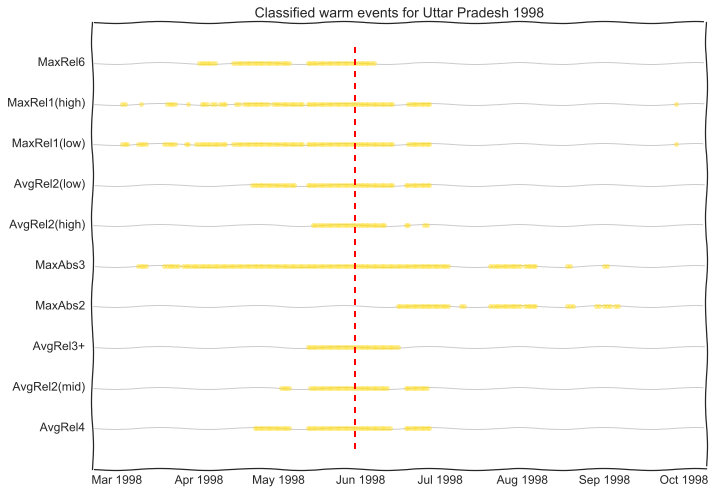

In [6]:
#--- Show days with warnings for an example year/location
# find date for report of 1998 event
report_dates = np.unique(filter(lambda x : x.split('/')[0] == '1998',
                                heatwave_data['Date (YMD)'][heatwave_data['Region'] == 'Uttar Pradesh']))
# write definition labels as the appear in the main text
definition_labels = ['AvgRel4','AvgRel2(mid)','AvgRel3+',
                     'MaxAbs2','MaxAbs3','AvgRel2(high)',
                     'AvgRel2(low)','MaxRel1(low)',
                     'MaxRel1(high)','MaxRel6']
# set the background colour
sns.set_style('white')
# create figure
fig, chart = plt.subplots(1,figsize=(11,8))
# initiate counter
count = 0
# loop over heat wave definitions
for definition in event_sequences.minor_axis : 
    # extract the signals and modify where they will be plotted on axis
    data = event_sequences['Uttar_Pradesh'].loc['1998-3':'1998-9',definition] + count
    # see when the thresholds are meet
    events = ( data == (1 + count) )
    # mark warm events
    _ = chart.scatter(data[events].index,data[events],
                      color=sns.xkcd_palette(['sun yellow']),
                      alpha=0.5)
    # iterate counter
    count += 1

# label date of reported heat wave cris
_ = chart.vlines(report_dates,ymin=0.5,ymax=10.5,linestyles='dashed',color='red')
# set the axis labels    
_ = chart.set_yticks(range(1,count+1))
_ = chart.set_yticklabels(definition_labels)
_ = chart.set_ylim(0,11)
_ = chart.tick_params(axis='both', which='major', labelsize=12)
# mark horizontal levels
_ = chart.yaxis.grid(True,linewidth=1)
# title figure
_ = chart.set_title('Classified warm events for Uttar Pradesh 1998',size=14)
# save the figure
plt.savefig('../figures/warm_events.Uttar_Pradesh_1998.png')